# Introduction 

This project aims to predict the price of an unknown laptop using the Laptop Price Dataset from Kaggle.

**The dataset contains 12 columns:**

1. Company- String -Laptop Manufacturer

2. Product -String -Brand and Model

3. TypeName -String -Type (Notebook, Ultrabook, Gaming, etc.)

4. Inches -Numeric- Screen Size

5. ScreenResolution -String- Screen Resolution

6. Cpu- String -Central Processing Unit (CPU)

7. Ram -String- Laptop RAM

8. Memory -String- Hard Disk / SSD Memory

9. GPU -String- Graphics Processing Units (GPU)

10. OpSys -String- Operating System

11. Weight -String- Laptop Weight

12. Price_euros -Numeric- Price (Euro)

# Outline

- import libraries 

- Data Cleaning 

- EDA

- Feature Engineering

- Modeling + Optimization 

- Results Summary


# Import libraries 

In [2]:
# ignore the warnings 
import warnings
warnings.filterwarnings("ignore")

# importing the libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts 


# Customizing matplotlib and seaborn Plots
sns.set_style("whitegrid")
sns.despine()

plt.style.use("ggplot") # you can use ggplot also 
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=16, titlepad=10)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from category_encoders import TargetEncoder

# modeling 
from sklearn.linear_model import LinearRegression,Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import optuna
from xgboost.callback import EarlyStopping

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import regex as re

seed = 10000

<Figure size 640x480 with 0 Axes>

In [3]:
# load the dataset
path = "laptop_price.csv"
df = pd.read_csv(path, encoding = "ISO-8859-1")
df.head(2)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94


In [4]:
num_rows = df.shape[0] 
num_cols = df.shape[1]

print(f"The number of columns are: {num_cols} and the number of rows are: {num_rows}")

The number of columns are: 13 and the number of rows are: 1303


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


- We have two numerical columns and all the others are categorical so we need to encode them 

In [6]:
numerical_cols = df.select_dtypes(include = np.number).columns.to_list()
categorical_cols = [col for col in df.columns if col not in numerical_cols]
print(numerical_cols)
print(categorical_cols)
print(len(numerical_cols + categorical_cols))

['laptop_ID', 'Inches', 'Price_euros']
['Company', 'Product', 'TypeName', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight']
13


In [7]:
df.describe()

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


# Data Cleaning

In [8]:
# the laptop_ID have no effect on the our target so let's drop it 
df = df.drop(columns=['laptop_ID'])

In [9]:
# let's rename the price_euros column ot price for simplicity
df = df.rename(columns={'Price_euros':'price'})

In [10]:
target = df['price']

#### Check duplicates

In [11]:
print(df.duplicated().sum())
df = df.drop_duplicates(keep='first')
print(df.duplicated().sum())

28
0


#### Check for missing values 

In [12]:
df.isnull().sum()

Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
price               0
dtype: int64

# EDA

In [13]:
# nice function that return nice plot, so let's create it 

# for numerical columns
def NumPlot(df, col, title):

    fig, ax = plt.subplots(2,1,figsize=(8,6),sharex=True)
    ax[0].set_title(title,fontsize=18)
    sns.boxplot(x=col,
                data=df,
                palette='Set2',
                ax=ax[0])
    ax[0].set(yticks=[])
    sns.histplot(x=col, data=df, ax=ax[1])
    ax[1].set_xlabel(col, fontsize=16)  
    plt.axvline(df[col].mean(), color='darkgreen', linewidth=2.2, label='mean=' + str(np.round(df[col].mean(),1)))
    plt.axvline(df[col].median(), color='red', linewidth=2.2, label='median='+ str(np.round(df[col].median(),1)))
    plt.axvline(df[col].mode()[0], color='purple', linewidth=2.2, label='mode='+ str(df[col].mode()[0]))
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=17, fancybox=True, shadow=True, frameon=True)
    plt.tight_layout()
    plt.show()



# For categorical columns 
def CatPlot(df, col, title):
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.countplot(x=col,
                    data = df,
                    palette='Set2',
                    order=df[col].value_counts().index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 40)

    for container in ax.containers:
        ax.bar_label(container)

    plt.title(title,fontsize=17)
    plt.xlabel(col,fontsize=13)
    plt.ylabel('Count',fontsize=13)

    plt.show()


### Check the number of unique values in each col

In [14]:
for col in df.columns:
    num = df[col].nunique()
    print(f"{col} : {num}")


Company : 19
Product : 618
TypeName : 6
Inches : 18
ScreenResolution : 40
Cpu : 118
Ram : 9
Memory : 39
Gpu : 110
OpSys : 9
Weight : 179
price : 791


### Company Columns

In [15]:
df['Company'].head()

0    Apple
1    Apple
2       HP
3    Apple
4    Apple
Name: Company, dtype: object

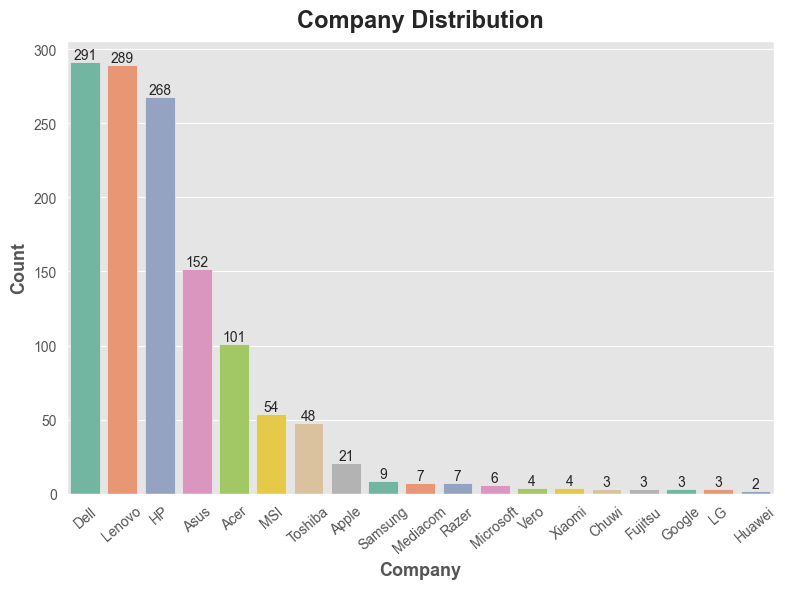

In [16]:
CatPlot(df,'Company','Company Distribution')

#### Results : 
- The encoding that we will apply on this column is **One hot encoding**
- The distribution is **skewed to the left**

### Product Columns

In [17]:
df['Product'].unique().tolist()[:10]

['MacBook Pro',
 'Macbook Air',
 '250 G6',
 'Aspire 3',
 'ZenBook UX430UN',
 'Swift 3',
 'Inspiron 3567',
 'MacBook 12"',
 'IdeaPad 320-15IKB',
 'XPS 13']

- This column has a lot of unique values about 618 values, it represents a hight-cardinality categorical variable so the best way to handle it is **Target Encoding**

### TypeName Column

In [18]:
df['TypeName'].head()

0    Ultrabook
1    Ultrabook
2     Notebook
3    Ultrabook
4    Ultrabook
Name: TypeName, dtype: object

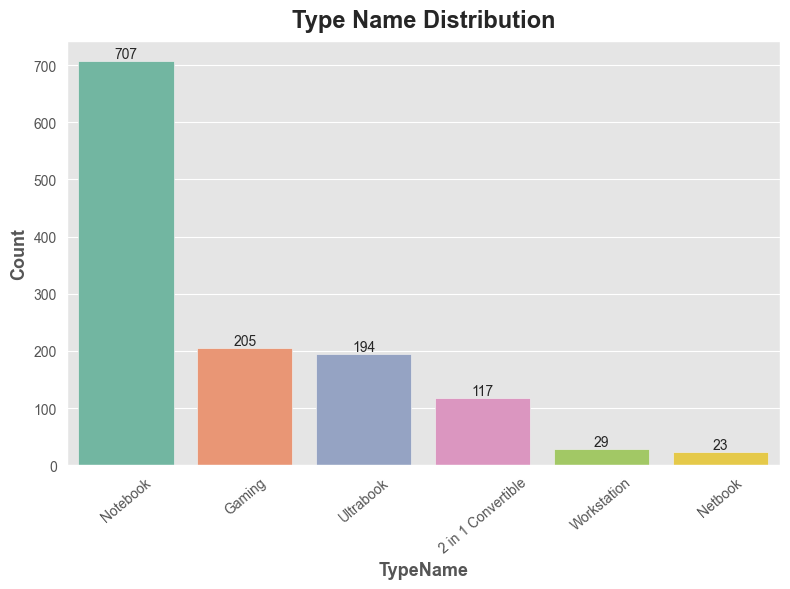

In [19]:
CatPlot(df,'TypeName','Type Name Distribution')

plt.show()

- We have just 6 unique values without any order so the best practice is **One-hot encoding technique**

### Inches Column

In [20]:
df['Inches'].unique()

array([13.3, 15.6, 15.4, 14. , 12. , 11.6, 17.3, 10.1, 13.5, 12.5, 13. ,
       18.4, 13.9, 12.3, 17. , 15. , 14.1, 11.3])

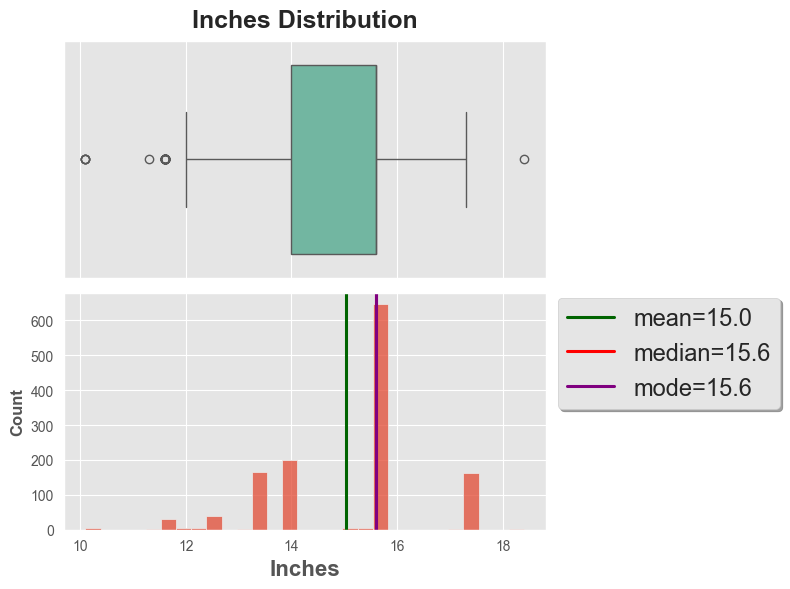

In [21]:
NumPlot(df,'Inches','Inches Distribution')

### ScreenResolution Column

In [22]:
df['ScreenResolution'].head()

0    IPS Panel Retina Display 2560x1600
1                              1440x900
2                     Full HD 1920x1080
3    IPS Panel Retina Display 2880x1800
4    IPS Panel Retina Display 2560x1600
Name: ScreenResolution, dtype: object

- here we have 40 unique values 
- we can extract more columns form here 
- **touchScreen** 
- **Resolution**
- after that wi will remove the **ScreenResolution** column and encode the **Resolution** column


### Cpu Column	

In [23]:
df['Cpu'].unique().tolist()[:10]

['Intel Core i5 2.3GHz',
 'Intel Core i5 1.8GHz',
 'Intel Core i5 7200U 2.5GHz',
 'Intel Core i7 2.7GHz',
 'Intel Core i5 3.1GHz',
 'AMD A9-Series 9420 3GHz',
 'Intel Core i7 2.2GHz',
 'Intel Core i7 8550U 1.8GHz',
 'Intel Core i5 8250U 1.6GHz',
 'Intel Core i3 6006U 2GHz']

- we can create a new feature from this one 
- **The cpu frequency** at the end GHz the remove the `GHz` string then convert the column into float data type
- then we will remove this part and we can perform the target encoding on one hot encoding to it.

### RAM column

In [24]:
df['Ram'].unique()

array(['8GB', '16GB', '4GB', '2GB', '12GB', '6GB', '32GB', '24GB', '64GB'],
      dtype=object)

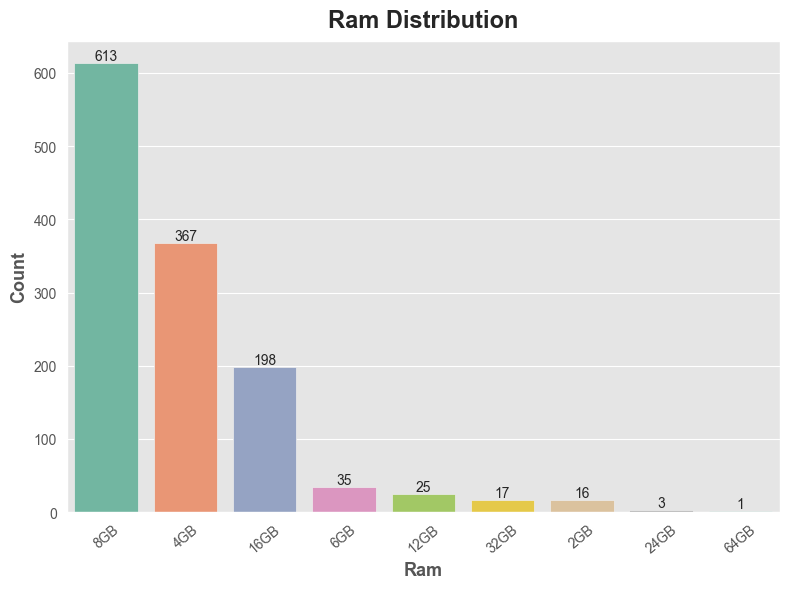

In [25]:
CatPlot(df,'Ram','Ram Distribution')

- we have just 6 unique values so the best is to remove the `GB` String and convert the column into float data type 

### Memory column

In [26]:
df['Memory'].unique()

array(['128GB SSD', '128GB Flash Storage', '256GB SSD', '512GB SSD',
       '500GB HDD', '256GB Flash Storage', '1TB HDD',
       '32GB Flash Storage', '128GB SSD +  1TB HDD',
       '256GB SSD +  256GB SSD', '64GB Flash Storage',
       '256GB SSD +  1TB HDD', '256GB SSD +  2TB HDD', '32GB SSD',
       '2TB HDD', '64GB SSD', '1.0TB Hybrid', '512GB SSD +  1TB HDD',
       '1TB SSD', '256GB SSD +  500GB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  512GB SSD', '16GB SSD', '16GB Flash Storage',
       '512GB SSD +  256GB SSD', '512GB SSD +  2TB HDD',
       '64GB Flash Storage +  1TB HDD', '180GB SSD', '1TB HDD +  1TB HDD',
       '32GB HDD', '1TB SSD +  1TB HDD', '512GB Flash Storage',
       '128GB HDD', '240GB SSD', '8GB SSD', '508GB Hybrid', '1.0TB HDD',
       '512GB SSD +  1.0TB Hybrid', '256GB SSD +  1.0TB Hybrid'],
      dtype=object)

- there are 39 unique values 
- we will create a new features and because some rows has two num of hard drives we will create 4 columns

- **storage of disk**: 
- **type of disk**: `SSD` `HDD` `Flash Storage` `Hybrid`

- apply this for the two disks




### OpSys Column

In [27]:
df['OpSys'].unique()

array(['macOS', 'No OS', 'Windows 10', 'Mac OS X', 'Linux', 'Android',
       'Windows 10 S', 'Chrome OS', 'Windows 7'], dtype=object)

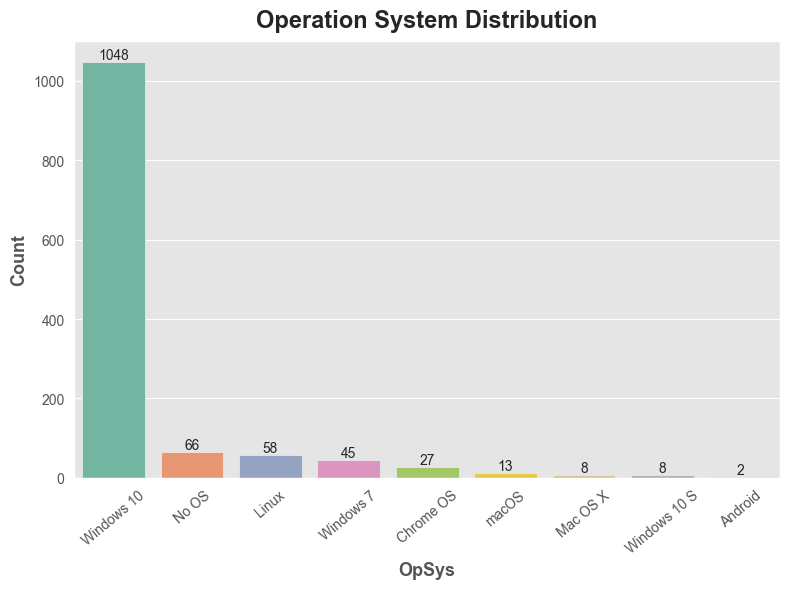

In [28]:
CatPlot(df,'OpSys','Operation System Distribution')

- we have just 9 values without any order so we will apply the **One hot encoding on it**

### Weight Column

In [29]:
df['Weight'].unique().tolist()[:10]

['1.37kg',
 '1.34kg',
 '1.86kg',
 '1.83kg',
 '2.1kg',
 '2.04kg',
 '1.3kg',
 '1.6kg',
 '2.2kg',
 '0.92kg']

- we will remove the `kg`string and convert it into float

### Price Column

In [30]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,price
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


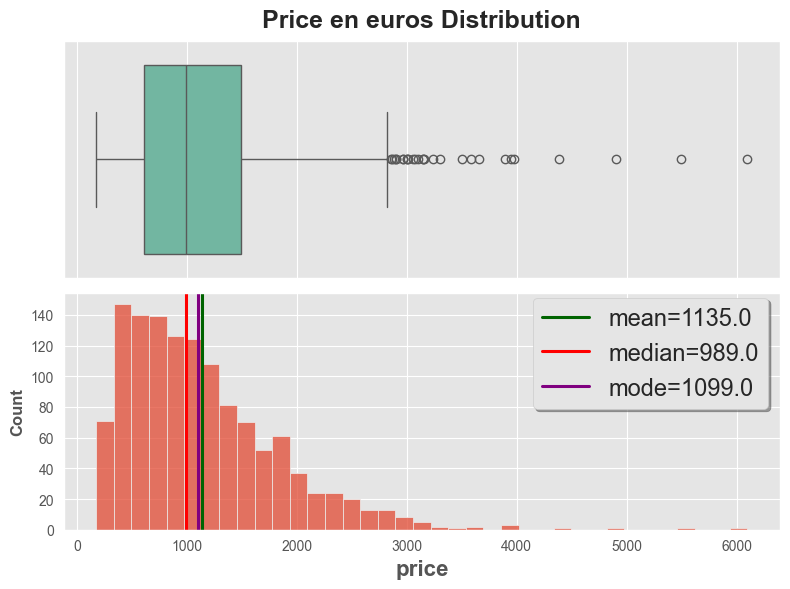

In [31]:
NumPlot(df,'price','Price en euros Distribution')

# Feature Engineering 

### Feature Extraction

- #### ScreenResolution col

In [32]:
df['ScreenResolution'].head()

0    IPS Panel Retina Display 2560x1600
1                              1440x900
2                     Full HD 1920x1080
3    IPS Panel Retina Display 2880x1800
4    IPS Panel Retina Display 2560x1600
Name: ScreenResolution, dtype: object

As we said:
- here we have 40 unique values 
- we can extract more columns form here 
- **ScreenType**
- **touchScreen** 
- **Resolution**
- after that wi will remove the **ScreenResolution** column and encode the **Resolution** column


##### Notes:
- `\d+x\d+`: this regular expression will extract the Resolution
- if we remove this RE from the ScreenResolution column we will get the ScreenType column
- Create the touchScreen column will contain either 0 or 1
- remove the ScreenResolution Column

In [33]:
df['resolution'] = df['ScreenResolution'].str.extract(r'(\d+x\d+)')

In [34]:
df['ScreenType'] = df['ScreenResolution'].replace(r'(\d+x\d+)','',regex=True)
df['ScreenType'] = df['ScreenType'].replace(r'^\s*$',np.nan,regex=True)

In [35]:
df['TouchScreen'] =df['ScreenType'].str.extract(r'(Touchscreen)').notna().astype(int)

In [36]:
df['ScreenType'] = df['ScreenType'].str.replace(r'(\/\sTouchscreen)','',regex=True)

In [37]:
df = df.drop('ScreenResolution', axis = 1)

In [38]:
df['resolution'].isnull().sum()

np.int64(0)

In [39]:
col = ["resolution", "ScreenType"]

for c in col:
    print(df[c].isnull().sum())
    print(df[c].nunique())

0
15
296
20


- handle the ScreenType missing values

In [40]:
df['ScreenType']= df['ScreenType'].replace(np.nan,df['ScreenType'].mode()[0])

- #### Cpu Col


In [41]:
df['Cpu'].head()

0          Intel Core i5 2.3GHz
1          Intel Core i5 1.8GHz
2    Intel Core i5 7200U 2.5GHz
3          Intel Core i7 2.7GHz
4          Intel Core i5 3.1GHz
Name: Cpu, dtype: object

- **The cpu frequency** at the end GHz the remove the `GHz` string then convert the column into float data type
- then we will remove this part and we can perform the target encoding on one hot encoding to it.

In [42]:
df['CpuFrequency'] = df['Cpu'].str.extract(r'(\d+\.?\d*GHz)')
df['CpuFrequency'] = df['CpuFrequency'].str.replace('GHz','').astype(float)
df['CpuFrequency'].head()

0    2.3
1    1.8
2    2.5
3    2.7
4    3.1
Name: CpuFrequency, dtype: float64

In [43]:
df['Cpu'] = df['Cpu'].str.replace(r'\d+\.?\d*GHz','',regex=True)
df['Cpu'].head()

0          Intel Core i5 
1          Intel Core i5 
2    Intel Core i5 7200U 
3          Intel Core i7 
4          Intel Core i5 
Name: Cpu, dtype: object

- We have 93 unique values for the Cpu col

- #### Ram

In [44]:
df['Ram'].unique()

array(['8GB', '16GB', '4GB', '2GB', '12GB', '6GB', '32GB', '24GB', '64GB'],
      dtype=object)

In [45]:
df['Ram'] = df['Ram'].str.replace('GB','').astype(int)
df['Ram'].head()

0     8
1     8
2     8
3    16
4     8
Name: Ram, dtype: int64

- #### Memory Columns

- there are 39 unique values 
- we will create a new features and because some rows has two num of hard drives we will create 4 columns

- **storage of disk**: 
- **type of disk**: `SSD` `HDD` `Flash Storage` `Hybrid`

- apply this for the two disks

In [46]:
df['Memory'] = df['Memory'].str.replace('1.0TB', '1000GB').str.replace('1TB', '1000GB').str.replace('2TB', '2000GB').str.replace('GB','')

In [47]:
df['Memory'] = df['Memory'].str.replace(' ','') 

In [48]:
df['Memory'].unique()

array(['128SSD', '128FlashStorage', '256SSD', '512SSD', '500HDD',
       '256FlashStorage', '1000HDD', '32FlashStorage', '128SSD+1000HDD',
       '256SSD+256SSD', '64FlashStorage', '256SSD+1000HDD',
       '256SSD+2000HDD', '32SSD', '2000HDD', '64SSD', '1000Hybrid',
       '512SSD+1000HDD', '1000SSD', '256SSD+500HDD', '128SSD+2000HDD',
       '512SSD+512SSD', '16SSD', '16FlashStorage', '512SSD+256SSD',
       '512SSD+2000HDD', '64FlashStorage+1000HDD', '180SSD',
       '1000HDD+1000HDD', '32HDD', '1000SSD+1000HDD', '512FlashStorage',
       '128HDD', '240SSD', '8SSD', '508Hybrid', '512SSD+1000Hybrid',
       '256SSD+1000Hybrid'], dtype=object)

In [49]:
df['storageDisk1'] = df['Memory'].str.extract(r'(^\d+)').astype(int)
df['storageDisk2'] = df['Memory'].str.extract(r'(\+\d+)')

TypeDisk1 = []
TypeDisk2 = []

for i in df['Memory']:
    if len(re.findall(r'\+',i)) == 1:
        allTypes = re.findall(r'([A-z]+)',i)
        TypeDisk1.append(allTypes[0])
        TypeDisk2.append(allTypes[1])
    else:
        allTypes = re.findall(r'([A-z]+)',i)
        TypeDisk1.append(allTypes[0])
        TypeDisk2.append(np.nan)
        
df['TypeDisk1'] = TypeDisk1
df['TypeDisk2'] = TypeDisk2


In [50]:
df['storageDisk2'] = df['storageDisk2'].fillna('0').str.replace('+', '').astype(int)

In [51]:
df['TypeDisk2'] = df['TypeDisk2'].fillna('NaN')

In [52]:
df = df.drop(columns=['Memory'], axis=1)

- #### Weight Col

In [53]:
df['Weight'].head()

0    1.37kg
1    1.34kg
2    1.86kg
3    1.83kg
4    1.37kg
Name: Weight, dtype: object

In [54]:
df['Weight'] = df['Weight'].str.replace('kg','').astype(float)

### Handling the columns

**One hot encoding** : 

- ***TypeName***
- ***TypeDisk1***
- ***TypeDisk2***
- ***OpSys***

**Target Encoding**

- ***Product***
- ***Resolution***

**Label Encoding**

- ***ScreenType***
- ***Cpu***
- ***Company***

**Numerical column**

- ***Inches***
- ***TouchScreen***
- ***CpuFrequency***
- ***Ram***
- ***storageDisk1***
- ***storageDisk2***
- ***Weight***

**Scaling Features**

- ***Ram***
- ***storageDisk1***
- ***storageDisk2***


In [55]:
df.describe()

,Inches,Ram,Weight,price,TouchScreen,CpuFrequency,storageDisk1,storageDisk2
count,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000
mean,15.022902,8.440784,2.040525,1134.969059,0.147451,2.302980,439.397647,171.984314
std,1.429470,5.097809,0.669196,700.752504,0.354694,0.503846,355.746953,406.236732
min,10.100000,2.000000,0.690000,174.000000,0.000000,0.900000,8.000000,0.000000
25%,14.000000,4.000000,1.500000,609.000000,0.000000,2.000000,256.000000,0.000000
50%,15.600000,8.000000,2.040000,989.000000,0.000000,2.500000,256.000000,0.000000
75%,15.600000,8.000000,2.310000,1496.500000,0.000000,2.700000,512.000000,0.000000
max,18.400000,64.000000,4.700000,6099.000000,1.000000,3.600000,2000.000000,2000.000000


## Pipeline

In [56]:
one_hot_columns = ['TypeName', 'TypeDisk1', 'TypeDisk2', 'OpSys']
target_encoded_columns = ['Product', 'resolution']
label_encoded_columns = ['ScreenType', 'Cpu','Gpu','Company']
numerical_columns = ['Inches', 'TouchScreen', 'CpuFrequency', 'Ram', 'storageDisk1', 'storageDisk2', 'Weight']
scaling_columns = ['Ram', 'storageDisk1', 'storageDisk2']

In [57]:
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(handle_unknown='ignore',drop='first'), one_hot_columns),
        ('target', TargetEncoder(), target_encoded_columns),
        ('label', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value= -1), label_encoded_columns),
        ('scaling', StandardScaler(), scaling_columns)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    steps=[
        ('preprocessor',preprocessor),
    ]
)
 

X_train, X_test, y_train, y_test = train_test_split(df, df['price'], test_size=0.2, random_state=42)

pipeline.fit(X_train,y_train)

X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [58]:
preprocessor = pipeline.named_steps['preprocessor']
transformed_feature_name = preprocessor.get_feature_names_out().tolist()


df_transformed = pd.DataFrame(
    X_train_transformed,
    columns=transformed_feature_name
)

df_transformed = df_transformed.apply(pd.to_numeric, errors='coerce')

df_transformed.head()

,one_hot__TypeName_Gaming,one_hot__TypeName_Netbook,one_hot__TypeName_Notebook,one_hot__TypeName_Ultrabook,one_hot__TypeName_Workstation,one_hot__TypeDisk1_HDD,one_hot__TypeDisk1_Hybrid,one_hot__TypeDisk1_SSD,one_hot__TypeDisk2_Hybrid,one_hot__TypeDisk2_NaN,...,label__Gpu,label__Company,scaling__Ram,scaling__storageDisk1,scaling__storageDisk2,remainder__Inches,remainder__Weight,remainder__price,remainder__TouchScreen,remainder__CpuFrequency
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,43.0,0.0,-0.060972,-0.528127,-0.423453,13.3,1.60,789.01,1.0,2.5
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,74.0,14.0,1.513485,0.194007,-0.423453,14.0,1.95,2899.00,0.0,2.8
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,43.0,10.0,-0.848200,-0.528127,-0.423453,15.6,2.10,867.00,1.0,2.3
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,21.0,4.0,-0.060972,1.570576,-0.423453,15.6,2.20,599.90,0.0,2.7
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,43.0,7.0,-0.848200,1.570576,-0.423453,15.6,1.86,469.00,0.0,2.0


In [59]:
df_transformed.shape

(1020, 33)

In [60]:
df_transformed.columns

Index(['one_hot__TypeName_Gaming', 'one_hot__TypeName_Netbook',
       'one_hot__TypeName_Notebook', 'one_hot__TypeName_Ultrabook',
       'one_hot__TypeName_Workstation', 'one_hot__TypeDisk1_HDD',
       'one_hot__TypeDisk1_Hybrid', 'one_hot__TypeDisk1_SSD',
       'one_hot__TypeDisk2_Hybrid', 'one_hot__TypeDisk2_NaN',
       'one_hot__TypeDisk2_SSD', 'one_hot__OpSys_Chrome OS',
       'one_hot__OpSys_Linux', 'one_hot__OpSys_Mac OS X',
       'one_hot__OpSys_No OS', 'one_hot__OpSys_Windows 10',
       'one_hot__OpSys_Windows 10 S', 'one_hot__OpSys_Windows 7',
       'one_hot__OpSys_macOS', 'target__Product', 'target__resolution',
       'label__ScreenType', 'label__Cpu', 'label__Gpu', 'label__Company',
       'scaling__Ram', 'scaling__storageDisk1', 'scaling__storageDisk2',
       'remainder__Inches', 'remainder__Weight', 'remainder__price',
       'remainder__TouchScreen', 'remainder__CpuFrequency'],
      dtype='object')

In [61]:
for col in df_transformed.columns:
    print(f'{col} : {df_transformed[col].isnull().sum()}')

one_hot__TypeName_Gaming : 0
one_hot__TypeName_Netbook : 0
one_hot__TypeName_Notebook : 0
one_hot__TypeName_Ultrabook : 0
one_hot__TypeName_Workstation : 0
one_hot__TypeDisk1_HDD : 0
one_hot__TypeDisk1_Hybrid : 0
one_hot__TypeDisk1_SSD : 0
one_hot__TypeDisk2_Hybrid : 0
one_hot__TypeDisk2_NaN : 0
one_hot__TypeDisk2_SSD : 0
one_hot__OpSys_Chrome OS : 0
one_hot__OpSys_Linux : 0
one_hot__OpSys_Mac OS X : 0
one_hot__OpSys_No OS : 0
one_hot__OpSys_Windows 10 : 0
one_hot__OpSys_Windows 10 S : 0
one_hot__OpSys_Windows 7 : 0
one_hot__OpSys_macOS : 0
target__Product : 0
target__resolution : 0
label__ScreenType : 0
label__Cpu : 0
label__Gpu : 0
label__Company : 0
scaling__Ram : 0
scaling__storageDisk1 : 0
scaling__storageDisk2 : 0
remainder__Inches : 0
remainder__Weight : 0
remainder__price : 0
remainder__TouchScreen : 0
remainder__CpuFrequency : 0


In [62]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   one_hot__TypeName_Gaming       1020 non-null   float64
 1   one_hot__TypeName_Netbook      1020 non-null   float64
 2   one_hot__TypeName_Notebook     1020 non-null   float64
 3   one_hot__TypeName_Ultrabook    1020 non-null   float64
 4   one_hot__TypeName_Workstation  1020 non-null   float64
 5   one_hot__TypeDisk1_HDD         1020 non-null   float64
 6   one_hot__TypeDisk1_Hybrid      1020 non-null   float64
 7   one_hot__TypeDisk1_SSD         1020 non-null   float64
 8   one_hot__TypeDisk2_Hybrid      1020 non-null   float64
 9   one_hot__TypeDisk2_NaN         1020 non-null   float64
 10  one_hot__TypeDisk2_SSD         1020 non-null   float64
 11  one_hot__OpSys_Chrome OS       1020 non-null   float64
 12  one_hot__OpSys_Linux           1020 non-null   f

## Correlation

In [63]:
corr = df_transformed.corr()['remainder__price'].sort_values(ascending=False)
corr = corr.to_frame().drop(['remainder__price'])
corr.style.background_gradient(cmap="RdYlBu")

,remainder__price
target__Product,0.836062
scaling__Ram,0.733379
target__resolution,0.599015
one_hot__TypeDisk1_SSD,0.513827
label__Cpu,0.511198
label__Gpu,0.448496
remainder__CpuFrequency,0.422277
one_hot__TypeName_Gaming,0.351112
one_hot__TypeName_Ultrabook,0.281471
scaling__storageDisk2,0.277645


## Modeling 

We will apply does algorithm to see what is the best one:

- Linear Regression (LinearRegression)
- Ridge Regression (Ridge)
- Lasso Regression (Lasso)
- Random Forest Regressor (RandomForestRegressor)
- Gradient Boosting Regressor (GradientBoostingRegressor)
- Support Vector Regressor (SVR) (SVR)
- XGBoost Regressor (XGBRegressor)

In [64]:
X = df_transformed.drop(columns=['remainder__price'])
y = df_transformed['remainder__price']

In [65]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regressor': SVR(),
    'XGBoost': XGBRegressor()
}


def evaluate_model(model,X_train_, X_test_, y_train_, y_test_):
    model.fit(X_train_, y_train_)
    y_pred = model.predict(X_test_)
    mse = mean_squared_error(y_test_, y_pred)
    r2 = r2_score(y_test_, y_pred)
    return mse, r2



results = {}
for name, model in models.items():
    mse, r2 = evaluate_model(model, X_train_, X_test_, y_train_, y_test_)
    results[name] = {'MSE': mse, 'R²': r2}

for name, metrics in results.items():
    print(f"{name}:MSE={metrics['MSE']:.3f}, R²={metrics['R²']:.3f}")

Linear Regression:MSE=106120.827, R²=0.840
Ridge Regression:MSE=105377.796, R²=0.841
Lasso Regression:MSE=104334.177, R²=0.843
Random Forest:MSE=62135.057, R²=0.906
Gradient Boosting:MSE=61432.326, R²=0.907
Support Vector Regressor:MSE=657927.096, R²=0.009
XGBoost:MSE=60753.771, R²=0.908


#### The best ine is **XGBoost**

#### with the help on ***optuna*** we will get the best parameter to improve the performance 

In [68]:
xgboost = XGBRegressor()

def objective(trial, X_train=X_train_, X_test=X_test_, y_train=y_train_, y_test=y_test_):
    param = {
        'objective' : 'reg:squarederror',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 5.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 5.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.001,0.01,0.05,0.1,0.2,0.25,0.3]),
        'n_estimators': trial.suggest_categorical('n_estimators', [300,400,500,1000,1500,2000,2500,3000]),
        'max_depth': trial.suggest_categorical('max_depth', [3,4,5,6,7]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
    }


    model = XGBRegressor(**param)
    model.fit(X_train_, y_train_, 
              eval_set=[(X_test_, y_test_)], 
              verbose=False)   
    preds = model.predict(X_test_)
    rmse = mean_squared_error(y_test, preds, squared=False)

    return rmse

In [69]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2024-09-12 21:26:49,516] A new study created in memory with name: no-name-0bac5bca-39e1-4fa6-9bc0-53ebdc546592
[I 2024-09-12 21:26:49,794] Trial 0 finished with value: 631.3149527309034 and parameters: {'lambda': 0.13611911236589527, 'alpha': 0.04757443410851285, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.001, 'n_estimators': 400, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 0 with value: 631.3149527309034.
[I 2024-09-12 21:26:50,386] Trial 1 finished with value: 262.76786233514844 and parameters: {'lambda': 0.29127948763344996, 'alpha': 0.07276524943176202, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.3, 'n_estimators': 1000, 'max_depth': 3, 'min_child_weight': 24}. Best is trial 1 with value: 262.76786233514844.
[I 2024-09-12 21:26:52,706] Trial 2 finished with value: 323.65890929676095 and parameters: {'lambda': 0.008871974327028501, 'alpha': 0.023928931234932817, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.001, 'n_e

In [70]:
# the best trial 

trial = study.best_trial
params = study.best_params

print(f'the best trail : {trial}')

print(f'the best params : {params}')

the best trail : FrozenTrial(number=31, state=1, values=[243.9126497990596], datetime_start=datetime.datetime(2024, 9, 12, 21, 27, 30, 628179), datetime_complete=datetime.datetime(2024, 9, 12, 21, 27, 33, 86924), params={'lambda': 2.231169364814, 'alpha': 4.844266113067927, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.3, 'n_estimators': 3000, 'max_depth': 3, 'min_child_weight': 55}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda': FloatDistribution(high=5.0, log=True, low=0.001, step=None), 'alpha': FloatDistribution(high=5.0, log=True, low=0.001, step=None), 'colsample_bytree': CategoricalDistribution(choices=(0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)), 'subsample': CategoricalDistribution(choices=(0.4, 0.5, 0.6, 0.7, 0.8, 1.0)), 'learning_rate': CategoricalDistribution(choices=(0.001, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3)), 'n_estimators': CategoricalDistribution(choices=(300, 400, 500, 1000, 1500, 2000, 2500, 3000)), 'max_depth': Categorical

In [71]:
params = []

for key, value in trial.params.items():
    params.append(value)
    print("    {}: {}".format(key, value))

    lambda: 2.231169364814
    alpha: 4.844266113067927
    colsample_bytree: 0.4
    subsample: 0.8
    learning_rate: 0.3
    n_estimators: 3000
    max_depth: 3
    min_child_weight: 55


In [72]:
xgb = XGBRegressor(params = params)
xgb.fit(X_train_, y_train_, 
            eval_set=[(X_test_, y_test_)], 
            verbose=False)   

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None,
             params=[2.231169364814, 4.844266113067927, 0.4, 0.8, 0.3, 3000, 3,
                     55], ...)

In [74]:
y_pred = xgb.predict(X_test_)

mse = mean_squared_error(y_test_, y_pred)
r2 = r2_score(y_test_,y_pred)

print(f'RMSE is : {np.round(np.sqrt(mse),2)}')
print(f'R2 score is : {np.round(r2,4)*100}%')


RMSE is : 246.48
R2 score is : 90.85%


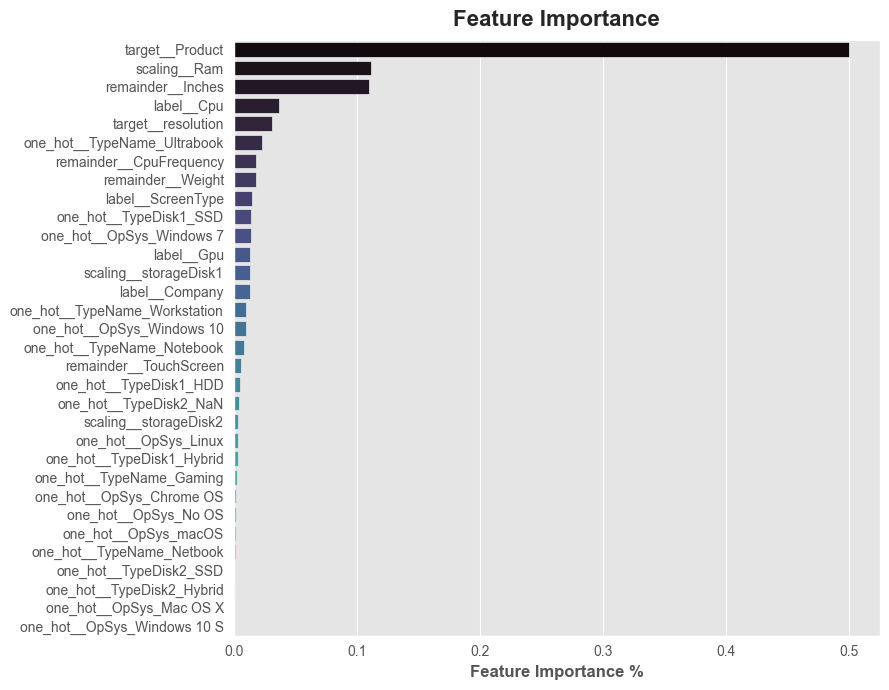

In [76]:
feature_names = X_train_.columns.tolist()

feature_importance_xbg_df = pd.DataFrame(
    {
        'feature' : feature_names,
        'importance' : xgb.feature_importances_
    }
)


feature_importance_xbg_df = feature_importance_xbg_df.sort_values(
    by='importance',
    ascending=False
)

plt.figure(figsize=(9,7))
sns.barplot(
    x='importance',
    y='feature',
    data= feature_importance_xbg_df,
    palette='mako'
)
plt.title('Feature Importance')
plt.xlabel('Feature Importance %')
plt.ylabel('')
plt.tight_layout
plt.show()

In [77]:
# at first we need to add the feature creation to the start of our pipeline so let's do it:
# here is all the preprocessing that we did above:


class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Extract resolution and ScreenType
        X['resolution'] = X['ScreenResolution'].str.extract(r'(\d+x\d+)')
        X['ScreenType'] = X['ScreenResolution'].replace(r'(\d+x\d+)', '', regex=True)
        X['ScreenType'] = X['ScreenType'].replace(r'^\s*$', np.nan, regex=True)
        
        # Extract TouchScreen
        X['TouchScreen'] = X['ScreenType'].str.extract(r'(Touchscreen)').notna().astype(int)
        X['ScreenType'] = X['ScreenType'].str.replace(r'(\/\sTouchscreen)', '', regex=True)
        X['ScreenType'] = X['ScreenType'].replace(np.nan, X['ScreenType'].mode()[0])

        # Drop ScreenResolution
        X = X.drop('ScreenResolution', axis=1)
        
        # Extract CpuFrequency
        X['CpuFrequency'] = X['Cpu'].str.extract(r'(\d+\.?\d*GHz)').replace('GHz', '', regex=True).astype(float)
        X['Cpu'] = X['Cpu'].str.replace(r'\d+\.?\d*GHz', '', regex=True)
        
        # Convert Ram
        X['Ram'] = X['Ram'].str.replace('GB', '').astype(int)
        
        # Process Memory
        X['Memory'] = X['Memory'].str.replace('1.0TB', '1000GB').str.replace('1TB', '1000GB').str.replace('2TB', '2000GB').str.replace('GB', '')
        X['Memory'] = X['Memory'].str.replace(' ', '')
        
        # Extract storageDisk1 and storageDisk2
        X['storageDisk1'] = X['Memory'].str.extract(r'(^\d+)').astype(int)
        X['storageDisk2'] = X['Memory'].str.extract(r'(\+\d+)')
        X['storageDisk2'] = X['storageDisk2'].fillna('0').str.replace('+', '').astype(int)

        # Extract TypeDisk1 and TypeDisk2
        TypeDisk1 = []
        TypeDisk2 = []
        for i in X['Memory']:
            if len(re.findall(r'\+', i)) == 1:
                allTypes = re.findall(r'([A-z]+)', i)
                TypeDisk1.append(allTypes[0])
                TypeDisk2.append(allTypes[1])
            else:
                allTypes = re.findall(r'([A-z]+)', i)
                TypeDisk1.append(allTypes[0])
                TypeDisk2.append(np.nan)
        
        X['TypeDisk1'] = TypeDisk1
        X['TypeDisk2'] = TypeDisk2
        X['TypeDisk2'] = X['TypeDisk2'].fillna('NaN')
        
        # Drop Memory column
        X = X.drop(columns=['Memory'], axis=1)
        
        # Convert Weight to numeric
        X['Weight'] = X['Weight'].str.replace('kg', '').astype(float)
        
        return X

In [91]:
# add the modeling to the pipeline and save it 

final_pipeline = Pipeline(
    steps=[
        ('feature_engineering', FeatureEngineeringTransformer()),
        ('preprocessor', preprocessor),
        ('modeling',XGBRegressor(**trial.params))
    ]
    
)

# to test all of this we will load the dataset again 

df_new = pd.read_csv(path, encoding = "ISO-8859-1")
df_new = df_new.drop(columns='laptop_ID')
X = df_new.drop(columns = 'Price_euros')
y = df_new['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

final_pipeline.fit(X_train, y_train)

final_pipeline

Pipeline(steps=[('feature_engineering', FeatureEngineeringTransformer()),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['TypeName', 'TypeDisk1',
                                                   'TypeDisk2', 'OpSys']),
                                                 ('target', TargetEncoder(),
                                                  ['Product', 'resolution']),
                                                 ('label',
                                                  OrdinalEncoder(handle_unknown='use_e...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              lambda=2.231169364814, learning_rate=0.3,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=55,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=3000,
                              n_jobs=None, ...))])

In [107]:
# test the pipeline 

data = {
    "Company": "Apple",
    "Product": "MacBook Air",
    "TypeName": "Ultrabook",
    "Inches": 10.08,
    "ScreenResolution": "IPS Panel Retina Display 2560x1600",
    "Cpu": "Intel Core i5 2.3GHz",
    "Ram": "8GB",
    "Memory": "128GB SSD",
    "Gpu": "Intel Iris Plus Graphics 640",
    "OpSys": "macOS",
    "Weight": "1.55kg"
}

test_df = pd.DataFrame([data])

predicted_price = final_pipeline.predict(test_df)
print(f"{np.round(predicted_price[0])} $")

964.0 $


In [109]:
import joblib 
joblib_file = "pipeline.joblib"
joblib.dump(final_pipeline, joblib_file)

print(f"pipeline saved to {joblib_file}")

pipeline saved to pipeline.joblib
